In [5]:
################################################################################
# Hedonic Pricing Model - Apartments (Julia)
# Script completo, optimizado (solo paquetes necesarios)
# Estructura: 3a Cleaning | 3b Modelos (OLS + FWL) | 3c Price premium
################################################################################

###############
# BLOQUE 0 - Instalar y cargar paquetes (solo lo necesario)
###############
import Pkg
Pkg.add(["CSV", "DataFrames", "GLM"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
Precompiling project...
           ✗ Makie
  0 dependencies successfully precompiled in 297 seconds. 504 already precompiled.
  1 dependency errored.
  For a report of the errors see `julia> err`. To retry use `pkg> precompile`


In [12]:
# Librerías necesarias
using Random
using Statistics
using LinearAlgebra
using Plots


In [18]:
# Fijar semilla para reproducibilidad
Random.seed!(123)

# Generación de datos
n = 1000
x = rand(n)             # Variable independiente ~ U(0,1)
e = randn(n)            # Ruido ~ N(0,1)
y = x .+ e              # Variable dependiente

# Rango de features
features_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

# Listas de resultados
r2_list = Float64[]
adj_r2_list = Float64[]
oos_r2_list = Float64[]

# Función para calcular R²
function r2_score(y, y_pred)
    ss_res = sum((y .- y_pred).^2)
    ss_tot = sum((y .- mean(y)).^2)
    return 1 - ss_res/ss_tot
end

# Loop principal
for p in features_range
    # Matriz de diseño (x, x², ..., x^p)
    X = hcat([x.^i for i in 1:p]...)

    # Estimación OLS (sin intercepto, β = (X'X)⁻¹X'y)
    β_hat = X \ y
    y_pred_full = X * β_hat

    # R² en muestra completa
    R_sq = r2_score(y, y_pred_full)
    push!(r2_list, R_sq)

    # R² ajustado
    if n > p + 1
        adjR_sq = 1 - (1 - R_sq) * (n - 1) / (n - p - 1)
    else
        adjR_sq = NaN
    end
    push!(adj_r2_list, adjR_sq)

    # Train/test split (75/25)
    idx = shuffle(1:n)
    train_idx = idx[1:round(Int, 0.75n)]
    test_idx  = idx[round(Int, 0.75n)+1:end]

    X_train, y_train = X[train_idx, :], y[train_idx]
    X_test, y_test   = X[test_idx, :], y[test_idx]

    β_train = X_train \ y_train
    y_pred_test = X_test * β_train

    # Out-of-sample R²
    if var(y_test) > 0
        oos_r2 = r2_score(y_test, y_pred_test)
    else
        oos_r2 = NaN
    end
    push!(oos_r2_list, oos_r2)
end

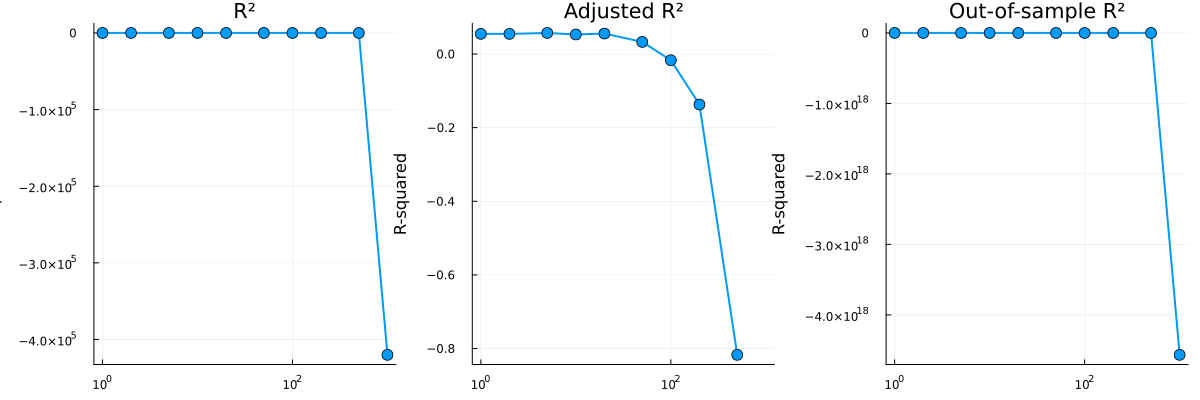

In [19]:
# Gráficos
plot1 = plot(features_range, r2_list, marker=:circle, line=:solid,
    xaxis=:log, xlabel="Número de features (escala log)", ylabel="R-squared",
    title="R²", legend=false, markersize=6, linewidth=2)

plot2 = plot(features_range, adj_r2_list, marker=:circle, line=:solid,
    xaxis=:log, xlabel="Número de features (escala log)", ylabel="R-squared",
    title="Adjusted R²", legend=false, markersize=6, linewidth=2)

plot3 = plot(features_range, oos_r2_list, marker=:circle, line=:solid,
    xaxis=:log, xlabel="Número de features (escala log)", ylabel="R-squared",
    title="Out-of-sample R²", legend=false, markersize=6, linewidth=2)

plot(plot1, plot2, plot3, layout=(1,3), size=(1200,400))